In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Define the URL of the Google Sheets containing the data
data_url = 'https://docs.google.com/spreadsheets/d/1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk/export?format=csv&gid=0'

# Use pandas to read the data
try:
    stock_data = pd.read_csv(data_url)
    print("Data loaded successfully!")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

# Display the first few rows of the dataframe
stock_data.head()

Data loaded successfully!


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",19.41,19.42,19.63,19.27,13.14M,-0.46%
1,"Mar 30, 2021",19.5,19.12,19.81,19.03,21.05M,2.09%
2,"Mar 29, 2021",19.1,19.24,19.67,19.1,16.56M,-0.78%
3,"Mar 26, 2021",19.25,20.28,20.36,19.1,21.35M,-3.85%
4,"Mar 25, 2021",20.02,20.5,20.86,20.02,15.93M,-1.48%


In [3]:
# Print the column names of the DataFrame
print(stock_data.columns)

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


In [4]:
# Import the regular expression library
import re

# Function to convert price to float after cleaning non-numeric characters
def clean_price(price):
    # Remove any text and extra characters, extract only the numeric part
    cleaned_price = re.sub(r'[^\d.]+', '', price)
    # Convert the cleaned price to float
    return float(cleaned_price)

# Apply the cleaning function to the 'Price' column
stock_data['Cleaned_Price'] = stock_data['Price'].apply(clean_price)

# Calculate the simple moving average (SMA) of the cleaned prices
stock_data['SMA_20'] = stock_data['Cleaned_Price'].rolling(window=20).mean()

# Calculate the standard deviation of the cleaned prices over the same period as SMA
stock_data['STD_20'] = stock_data['Cleaned_Price'].rolling(window=20).std()

# Calculate the Upper Bollinger Band
stock_data['Upper_Band'] = stock_data['SMA_20'] + (stock_data['STD_20'] * 2)

# Calculate the Lower Bollinger Band
stock_data['Lower_Band'] = stock_data['SMA_20'] - (stock_data['STD_20'] * 2)

# Display the head of the DataFrame to see the Bollinger Bands columns
stock_data[['Date', 'Cleaned_Price', 'SMA_20', 'Upper_Band', 'Lower_Band']].head()

,Date,Cleaned_Price,SMA_20,Upper_Band,Lower_Band
0,"Mar 31, 2021",19.41,NaN,NaN,NaN
1,"Mar 30, 2021",19.50,NaN,NaN,NaN
2,"Mar 29, 2021",19.10,NaN,NaN,NaN
3,"Mar 26, 2021",19.25,NaN,NaN,NaN
4,"Mar 25, 2021",20.02,NaN,NaN,NaN


In [5]:
# Function to determine trading signals
def trading_signals(data):
    if data['Cleaned_Price'] < data['Lower_Band']:
        return 'Buy'
    elif data['Cleaned_Price'] > data['Upper_Band']:
        return 'Sell'
    else:
        return 'Hold'

# Apply the function to the DataFrame
stock_data['Trade_Signal'] = stock_data.apply(trading_signals, axis=1)

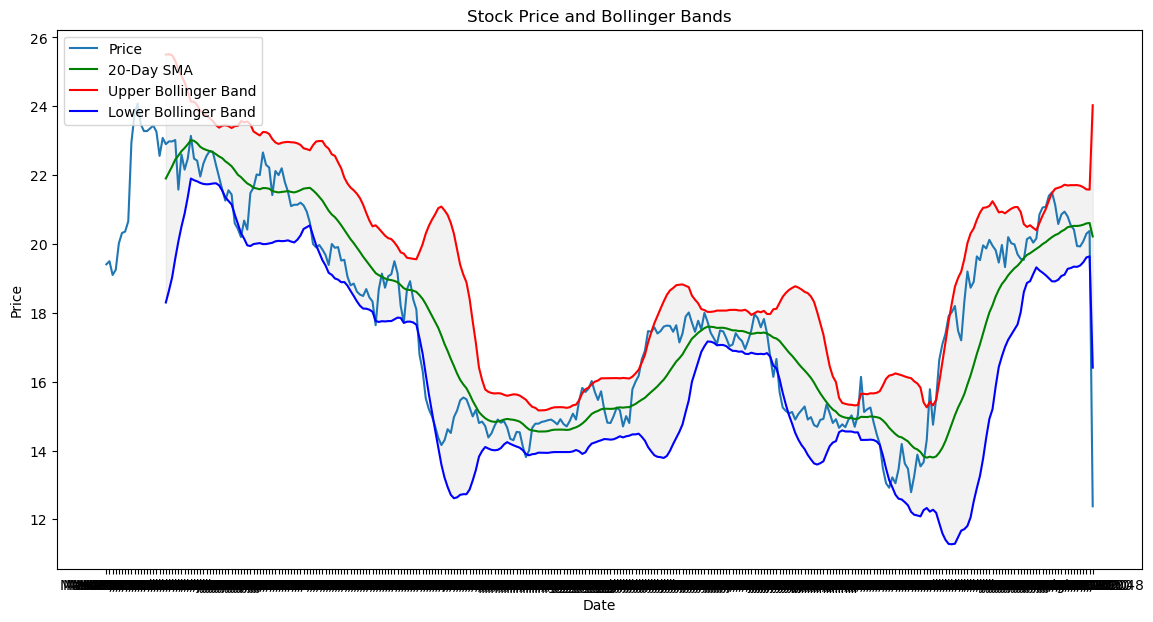

In [6]:
# Plotting the prices along with the Bollinger Bands
plt.figure(figsize=(14,7))
plt.plot(stock_data['Date'], stock_data['Cleaned_Price'], label='Price')
plt.plot(stock_data['Date'], stock_data['SMA_20'], label='20-Day SMA', color='green')
plt.plot(stock_data['Date'], stock_data['Upper_Band'], label='Upper Bollinger Band', color='red')
plt.plot(stock_data['Date'], stock_data['Lower_Band'], label='Lower Bollinger Band', color='blue')
plt.fill_between(stock_data['Date'], stock_data['Lower_Band'], stock_data['Upper_Band'], color='gray', alpha=0.1)
plt.title('Stock Price and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

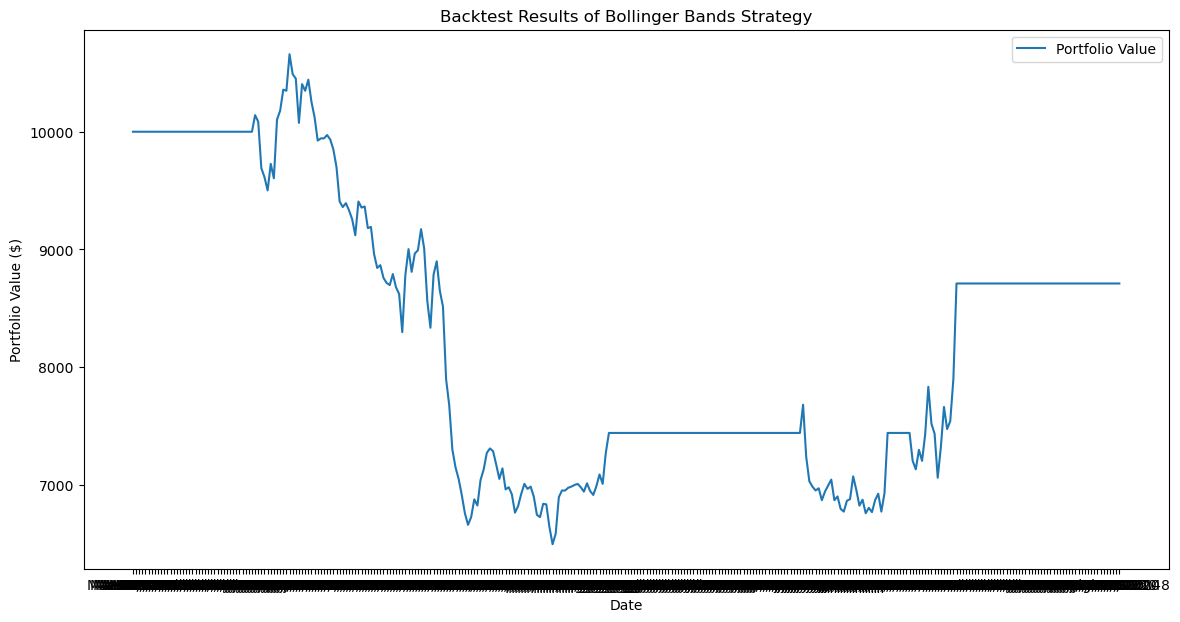

Total return over the period: -12.89%


In [7]:
# Initialize capital and positions for backtesting
initial_capital = 10000
positions = 0
capital = initial_capital
portfolio = []

# Simulate the trading strategy
for index, row in stock_data.iterrows():
    if row['Trade_Signal'] == 'Buy' and positions == 0:
        positions = capital / row['Cleaned_Price']
        capital = 0  # Invest all capital
    elif row['Trade_Signal'] == 'Sell' and positions > 0:
        capital = positions * row['Cleaned_Price']
        positions = 0  # Sell all positions

    # Calculate total portfolio value (cash + holdings)
    portfolio_value = capital + positions * row['Cleaned_Price']
    portfolio.append(portfolio_value)

# Plot portfolio value over time
plt.figure(figsize=(14,7))
plt.plot(stock_data['Date'], portfolio, label='Portfolio Value')
plt.title('Backtest Results of Bollinger Bands Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Evaluate performance
final_value = portfolio[-1]
total_return = ((final_value - initial_capital) / initial_capital) * 100
print(f"Total return over the period: {total_return:.2f}%")